In [1]:
import numpy as np
import matplotlib.pyplot as plt
import visualization
from math import tan, atan, radians, degrees

In [27]:
# by https://stackoverflow.com/questions/2891790/how-to-pretty-printing-a-numpy-array-without-scientific-notation-and-with-given
import contextlib

@contextlib.contextmanager
def printoptions(*args, **kwargs):
    original = np.get_printoptions()
    np.set_printoptions(*args, **kwargs)
    try:
        yield
    finally: 
        np.set_printoptions(**original)
        

In [89]:
def construct_proj_matrix(H=1080, W=1914, fov=50.0, near_clip=1.5):
    # for z coord
    f = near_clip  # the near clip, but f in the book
    n = 10003.815  # the far clip, rounded value of median, after very weird values were discarded
    # x coord
    r = W * n * tan(radians(fov) / 2) / H
    l = -r
    # y coord
    t = n * tan(radians(fov) / 2)
    b = -t
    # x00 = 2*n/(r-l)
    x00 = H / (tan(radians(fov) / 2) * W)
    # x11 = 2*n/(t-b)
    x11 = 1 / tan(radians(fov) / 2)
    return np.array([
        [x00, 0, -(r + l) / (r - l), 0],
        [0, x11, -(t + b) / (t - b), 0],
        [0, 0, -f / (f - n), -f * n / (f - n)],
        [0, 0, -1, 0],
    ])

def calc_matrix_params(proj):
    x22 = proj[2, 2]
    x23 = proj[2, 3]
    n = -x23 / x22
    f = -x23 / (x22 - 1)
    return n, f

In [3]:
ini_file = "gta-postprocessing.ini"
visualization.multi_page = False
visualization.ini_file = ini_file

conn = visualization.get_connection()
cur = conn.cursor()
cur.execute("""SELECT snapshot_id, imagepath, proj_matrix \
  FROM snapshots \
  WHERE run_id = 6
  ORDER BY snapshot_id DESC \
  """)

results = []
for row in cur:
    res = dict(row)
    res['proj_matrix'] = np.array(res['proj_matrix'])
    results.append(res)

print('There are {} records'.format(len(results)))
projs = [i['proj_matrix'] for i in results]

# todo: estimate far plane by least squares. The rest is known. Before that, get rid of all outliers
# x00 = proj[0, 0]
# x11 = proj[1, 1]
x22s = np.array([proj[2, 2] for proj in projs])
x23s = np.array([proj[2, 3] for proj in projs])

ns = -x23s / x22s
fs = -x23s / (x22s - 1)

There are 33293 records


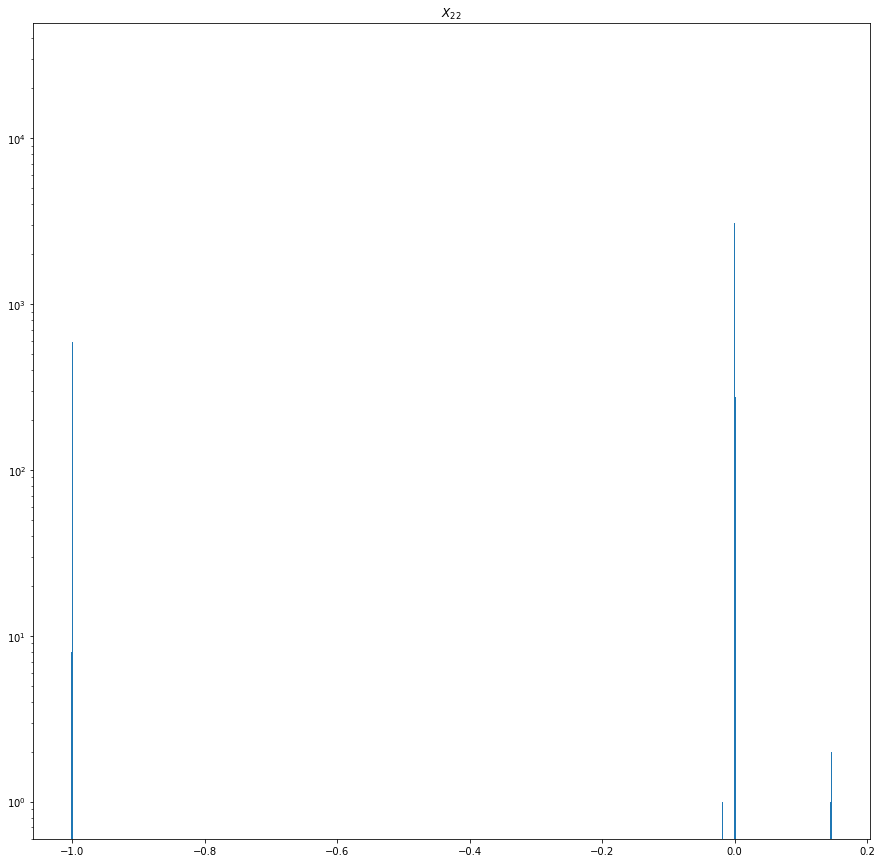

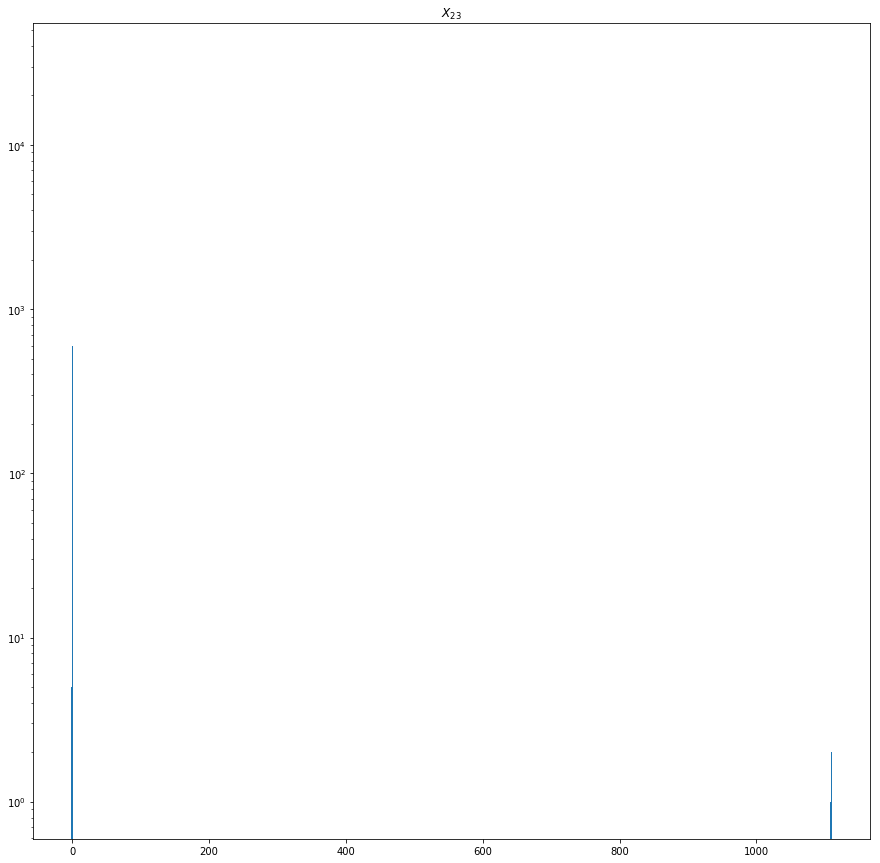

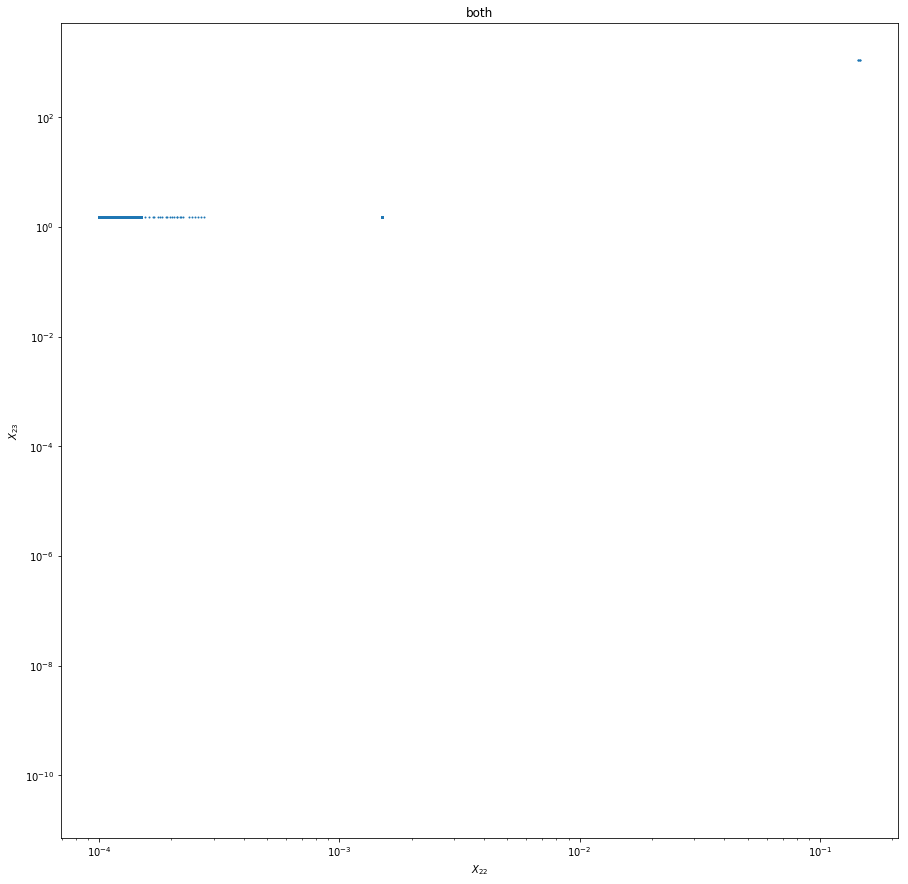

In [23]:
# showing plots with values
%matplotlib inline

fig = plt.figure(figsize=(14, 14))
plt.yscale('log', nonposy='clip')
plt.title('$X_{22}$')
plt.hist(x22s, bins=1000)

fig = plt.figure(figsize=(14, 14))
plt.yscale('log', nonposy='clip')
plt.title('$X_{23}$')
plt.hist(x23s, bins=1000)


fig = plt.figure(figsize=(14, 14))
plt.title('both')
plt.xlabel('$X_{22}$')
plt.ylabel('$X_{23}$')
plt.loglog(x22s, x23s, 'o', markersize=1)
plt.show()

In [51]:
# showing weird matrices
with printoptions(precision=5, suppress=True):
    print('weird x22 value in proj: ')
    weird_projs = [proj for proj in projs if abs(proj[2, 2] - (-1)) < 1e-4]
    for weird_proj in weird_projs:
        print(weird_proj)
        print(calc_matrix_params(weird_proj))
    
    print('correct proj')
    print(projs[0])
    print(calc_matrix_params(projs[0]))

    print('weird x23 value in proj: ')
    weird_projs = [proj for proj in projs if proj[2, 3] > 1000]
    for weird_proj in weird_projs:
        print(weird_proj)
        print(calc_matrix_params(weird_proj))
    
    print('correct proj')
    print(projs[0])
    print(calc_matrix_params(projs[0]))



weird x22 value in proj: 
[[ 1.21007 -0.       0.      -0.00003]
 [ 0.       2.14451 -0.      -0.     ]
 [ 0.      -0.      -1.      -0.00003]
 [-0.       0.      -1.       0.     ]]
(-2.8936579171896971e-05, -1.446828244810287e-05)
[[ 1.21007 -0.       0.      -0.00005]
 [ 0.       2.14451 -0.       0.00001]
 [ 0.      -0.      -1.       0.00007]
 [ 0.       0.      -1.       0.     ]]
(6.9314628883821911e-05, 3.4657296608361323e-05)
[[ 1.21007 -0.      -0.       0.00006]
 [ 0.       2.14451 -0.      -0.     ]
 [ 0.       0.      -1.      -0.00012]
 [ 0.       0.      -1.       0.     ]]
(-0.00012038641549108767, -6.0193176559244511e-05)
correct proj
[[ 1.21007  0.      -0.       0.0001 ]
 [ 0.       2.14451  0.       0.     ]
 [ 0.       0.       0.00015  1.50022]
 [ 0.       0.      -1.       0.     ]]
(-10003.814890496365, 1.5004499736000467)
weird x23 value in proj: 
[[    1.21007    -0.          0.         -0.00007]
 [    0.          2.14451    -0.         -0.     ]
 [    0.     

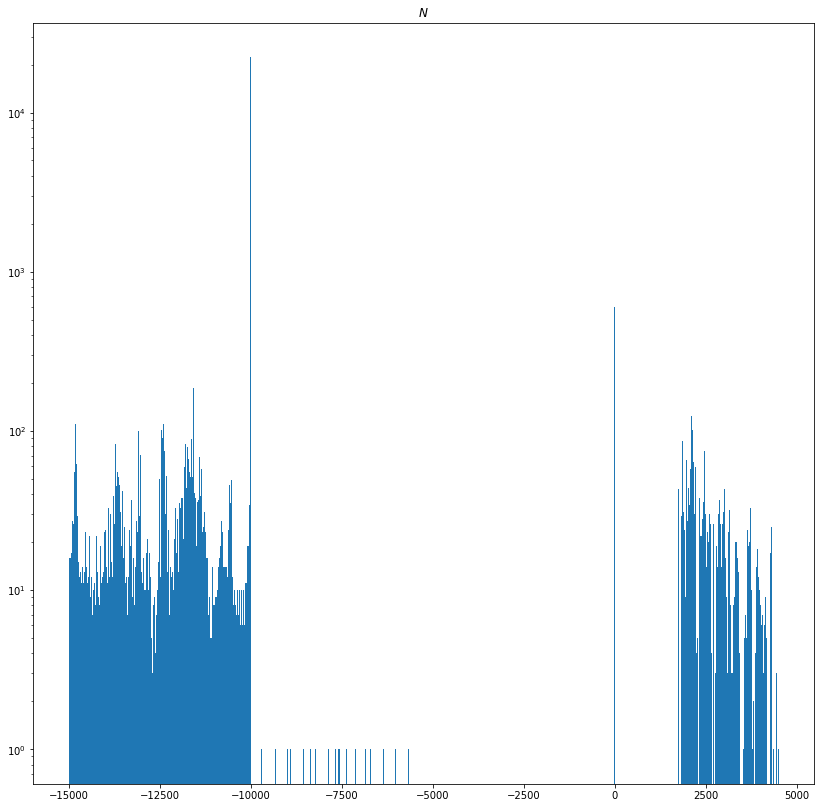

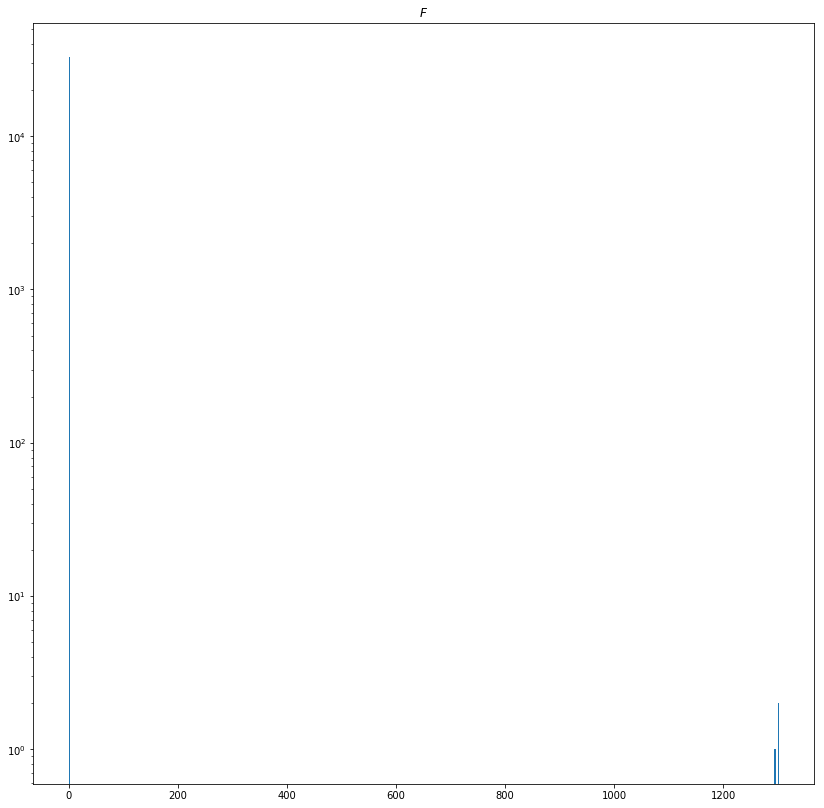

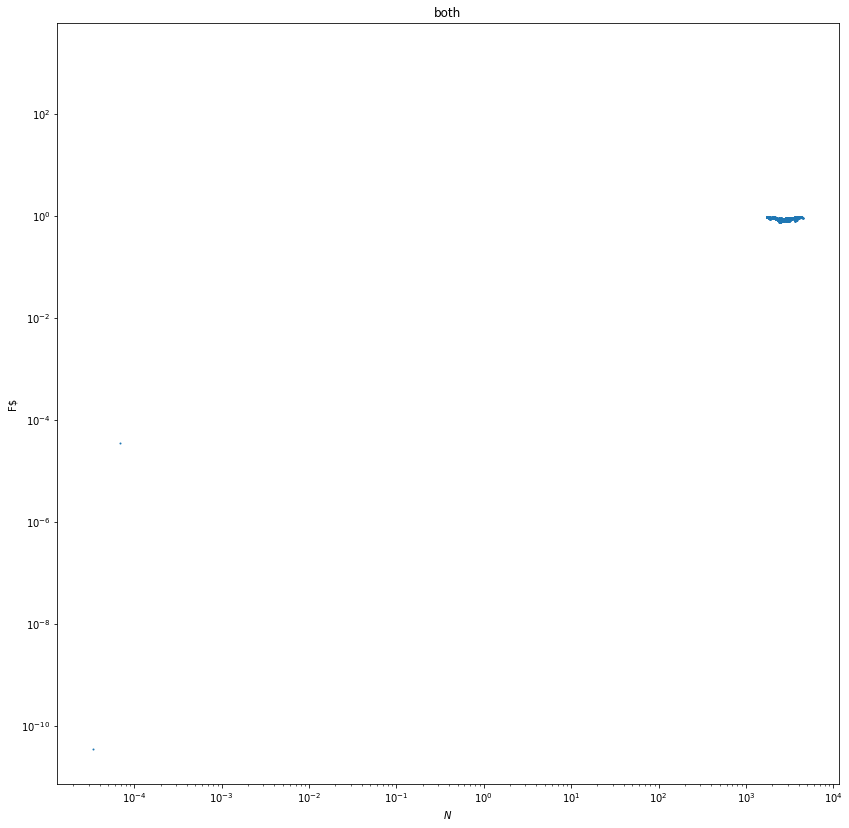

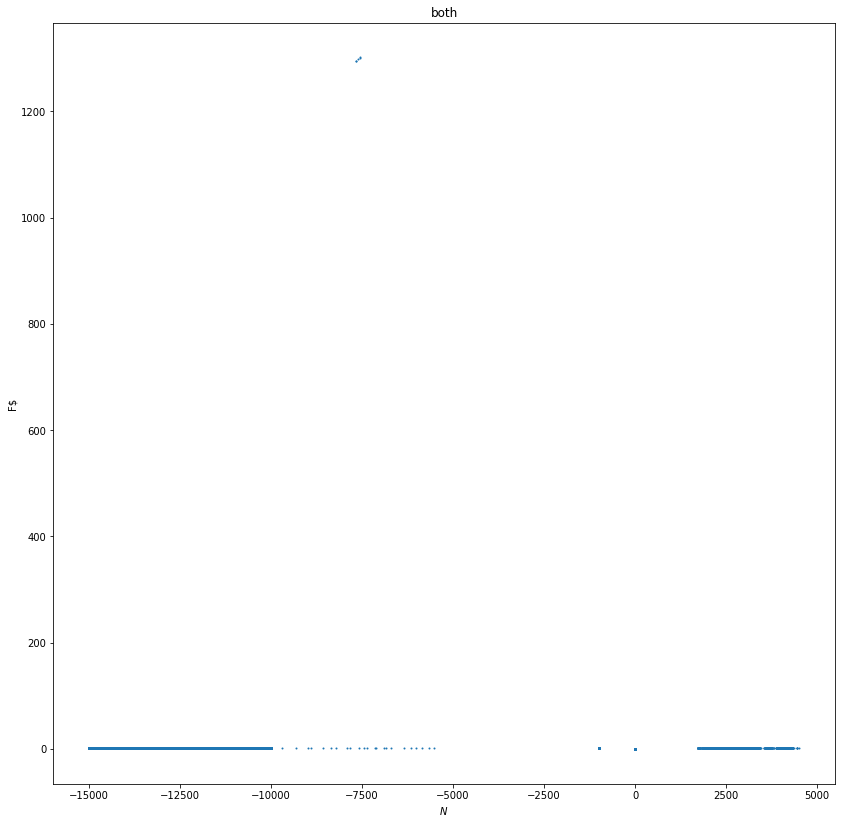

In [57]:
# showing plots with n and f
%matplotlib inline
# axes[0].plot(x22s, np.zeros_like(x22s), 'x')
fig = plt.figure(figsize=(14, 14))
plt.yscale('log', nonposy='clip')
plt.title('$N$')
plt.hist(ns, bins=1000)

fig = plt.figure(figsize=(14, 14))
plt.yscale('log', nonposy='clip')
plt.title('$F$')
plt.hist(fs, bins=1000)

fig = plt.figure(figsize=(14, 14))
plt.title('both')
plt.xlabel('$N$')
plt.ylabel('F$')
plt.loglog(ns, fs, 'o', markersize=1)
plt.show()

fig = plt.figure(figsize=(14, 14))
plt.title('both')
plt.xlabel('$N$')
plt.ylabel('F$')
plt.plot(ns, fs, 'o', markersize=1)
plt.show()

In [71]:
# filtered weird values
# this filters only very weird values
correct_projs = [proj for proj in projs if abs(proj[2, 2] - (-1)) > 1e-2 and proj[2, 3] < 1e3]
# this filters bassed on knowledge of near clip (far clip in terminilogy of equations, f)
correct_projs = [proj for proj in correct_projs if abs((-proj[2, 3] / (proj[2, 2] - 1)) - 1.5) < 5e-4]
x22s = np.array([proj[2, 2] for proj in correct_projs])
x23s = np.array([proj[2, 3] for proj in correct_projs])

ns = -x23s / x22s
fs = -x23s / (x22s - 1)

print('all values count: ', len(projs))
print('correct values count: ', len(correct_projs))
print('filtered count: ', len(projs) - len(correct_projs))

all values count:  33293
correct values count:  29324
filtered count:  3969


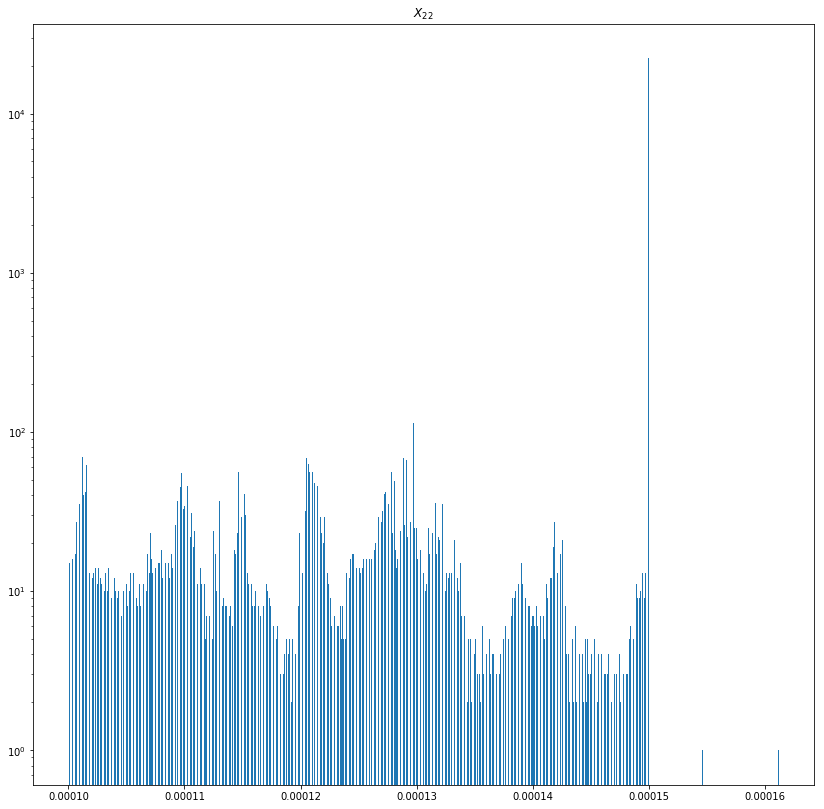

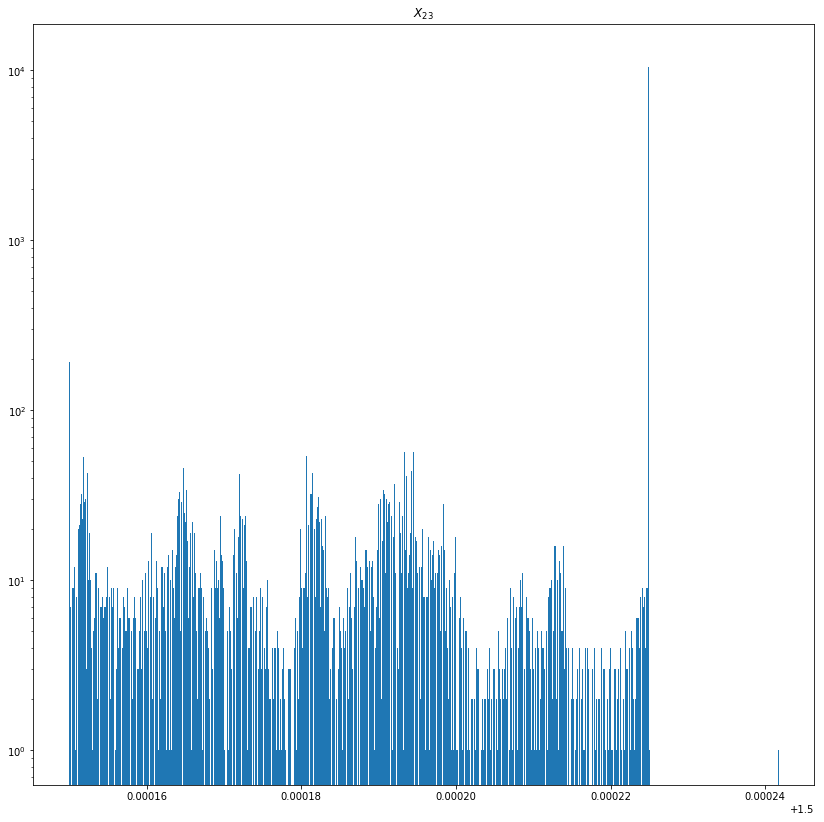

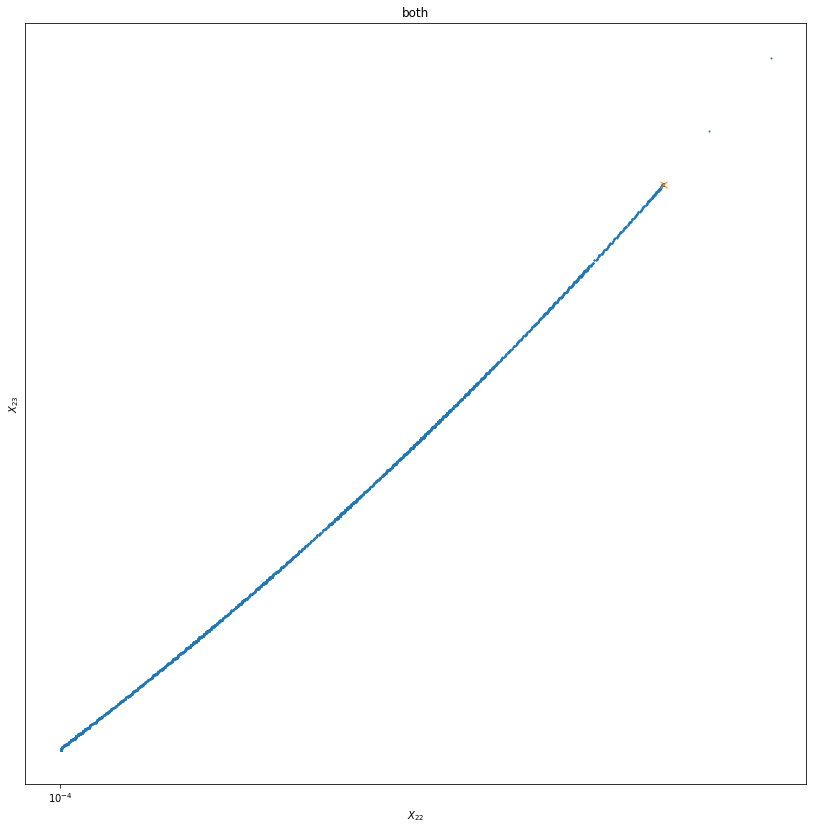

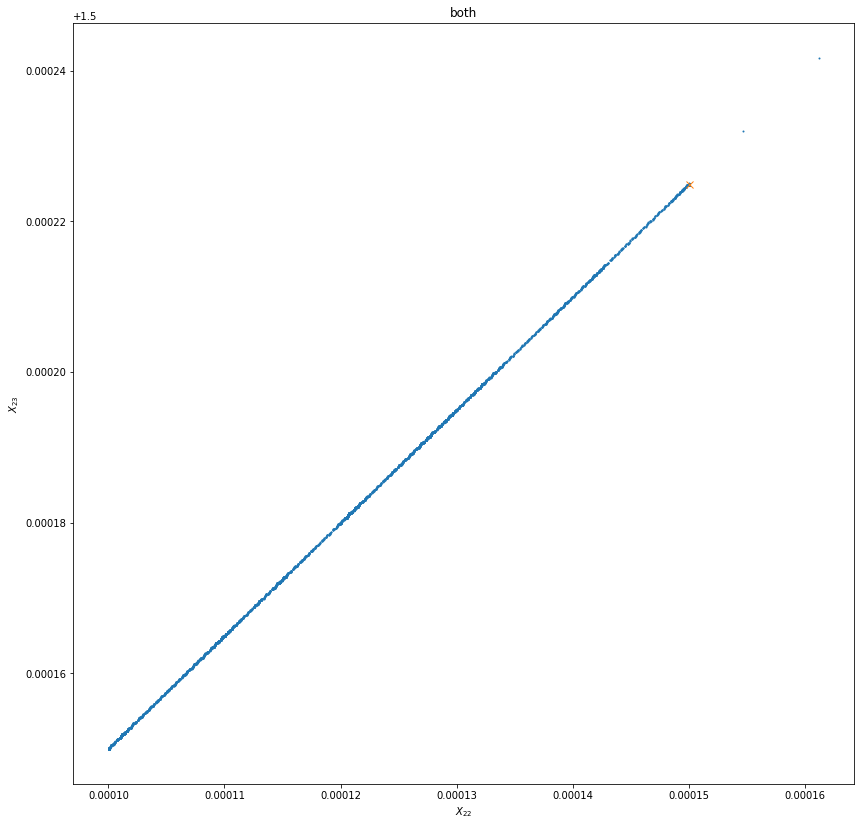

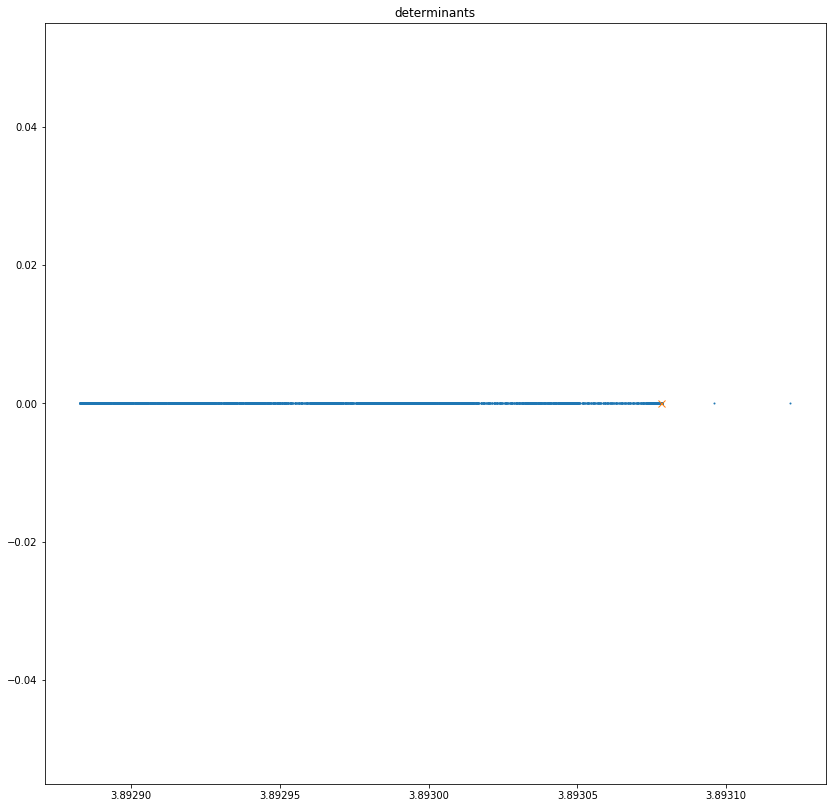

In [96]:
# showing plots with values
%matplotlib inline

fig = plt.figure(figsize=(14, 14))
plt.yscale('log', nonposy='clip')
plt.title('$X_{22}$')
plt.hist(x22s, bins=1000)

fig = plt.figure(figsize=(14, 14))
plt.yscale('log', nonposy='clip')
plt.title('$X_{23}$')
plt.hist(x23s, bins=1000)


my_proj = construct_proj_matrix()

fig = plt.figure(figsize=(14, 14))
plt.title('both')
plt.xlabel('$X_{22}$')
plt.ylabel('$X_{23}$')
plt.loglog(x22s, x23s, 'o', markersize=1)
plt.plot(my_proj[2, 2], my_proj[2, 3], 'x', markersize=7)
plt.show()

fig = plt.figure(figsize=(14, 14))
plt.title('both')
plt.xlabel('$X_{22}$')
plt.ylabel('$X_{23}$')
plt.plot(x22s, x23s, 'o', markersize=1)
plt.plot(my_proj[2, 2], my_proj[2, 3], 'x', markersize=7)
plt.show()

dets = [np.linalg.det(proj) for proj in correct_projs]
fig = plt.figure(figsize=(14, 14))
plt.title('determinants')
plt.plot(dets, np.zeros_like(dets), 'o', markersize=1)
plt.plot(np.linalg.det(my_proj), 0, 'x', markersize=7)
plt.show()


c:\users\azathoth\appdata\local\programs\python\python35\lib\site-packages\matplotlib\ticker.py:2210: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


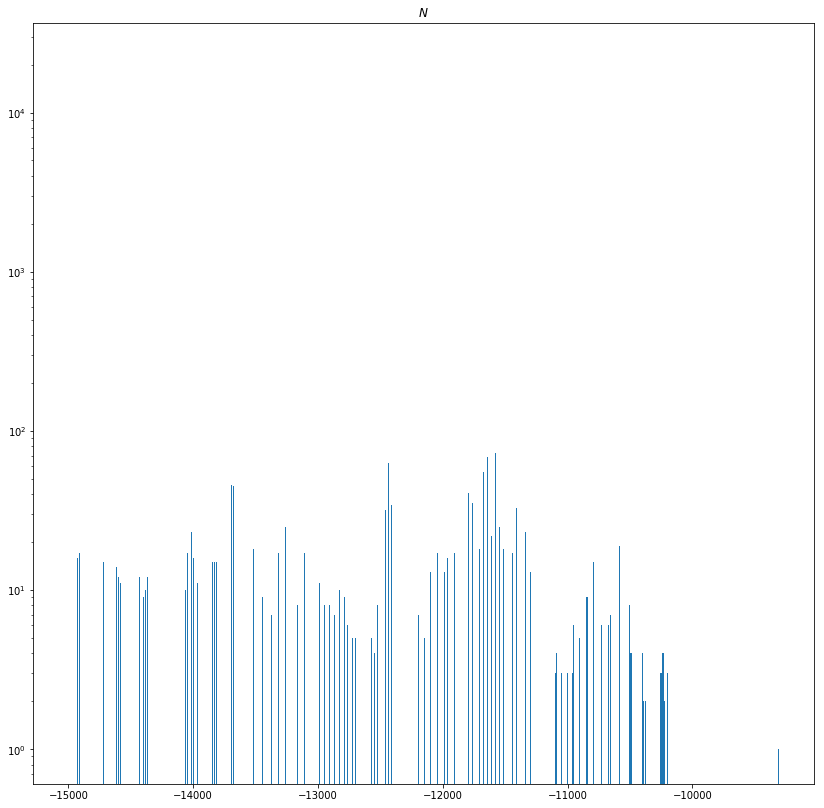

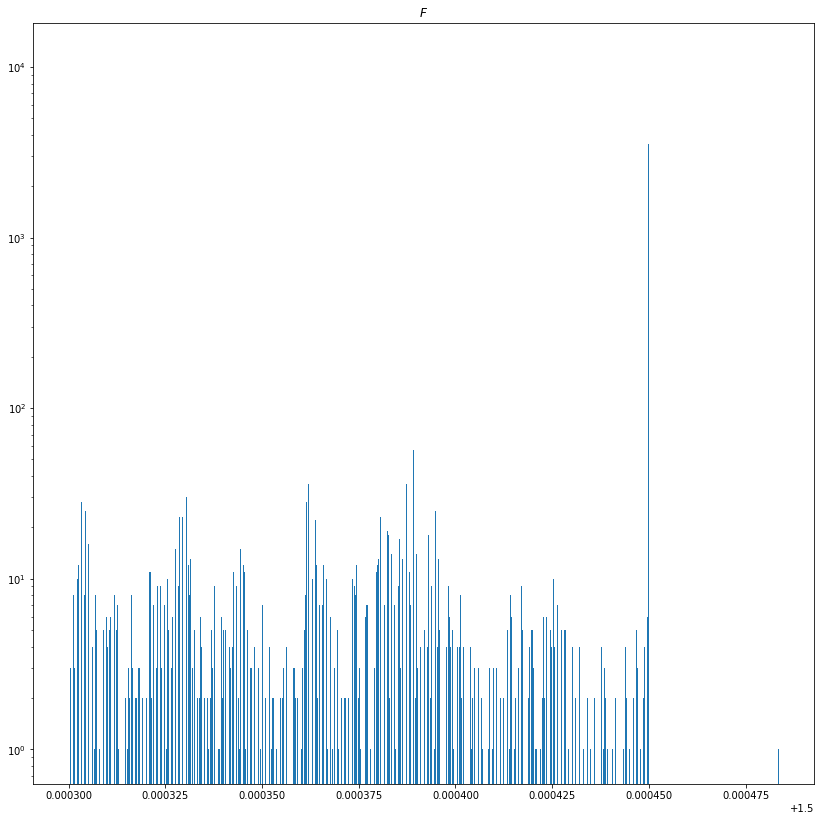

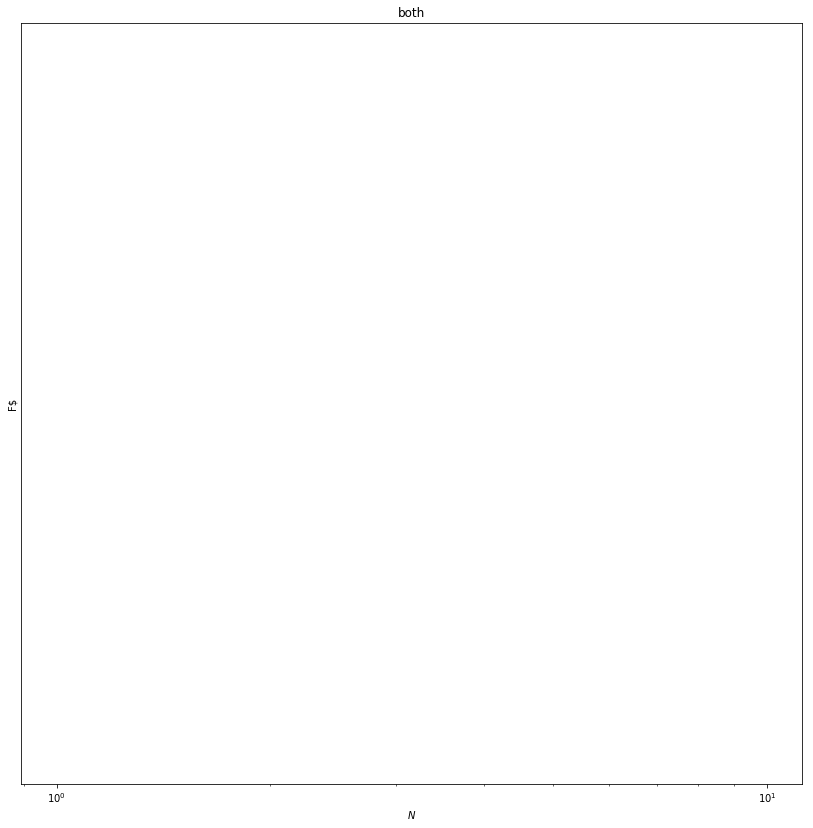

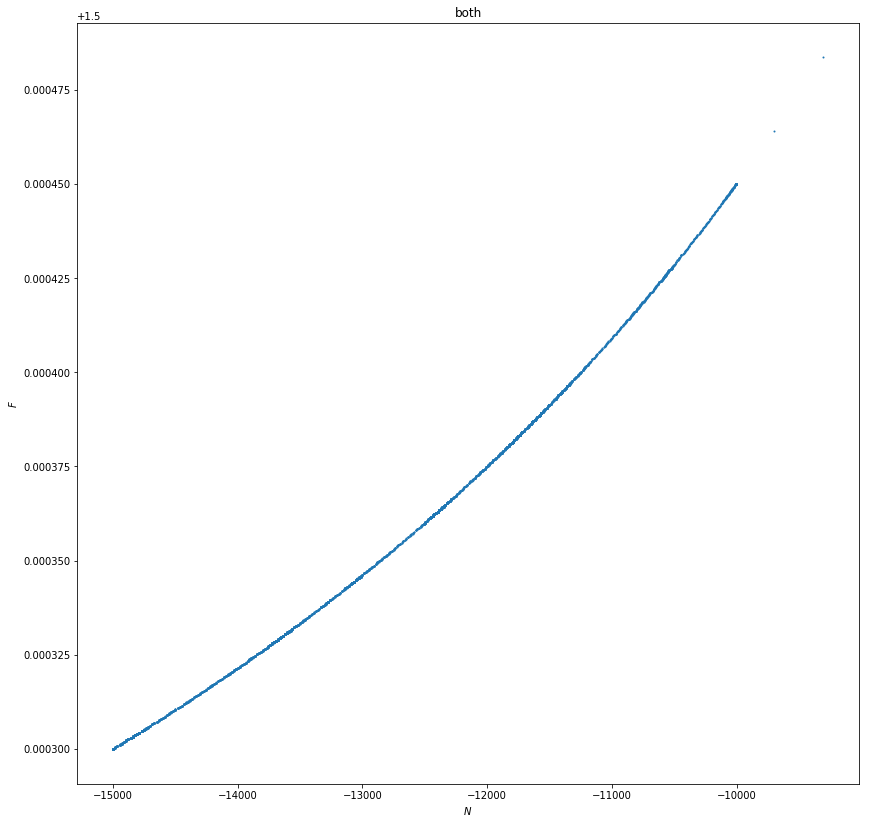

In [85]:
# showing plots with n and f
%matplotlib inline
# axes[0].plot(x22s, np.zeros_like(x22s), 'x')
fig = plt.figure(figsize=(14, 14))
plt.yscale('log', nonposy='clip')
plt.title('$N$')
plt.hist(ns, bins=3000)

fig = plt.figure(figsize=(14, 14))
plt.yscale('log', nonposy='clip')
plt.title('$F$')
plt.hist(fs, bins=3000)

fig = plt.figure(figsize=(14, 14))
plt.title('both')
plt.xlabel('$N$')
plt.ylabel('F$')
plt.loglog(ns, fs, 'o', markersize=1)
plt.show()

fig = plt.figure(figsize=(14, 14))
plt.title('both')
plt.xlabel('$N$')
plt.ylabel('$F$')
plt.plot(ns, fs, 'o', markersize=1)
plt.show()

In [88]:
# fat clip, which I know precisely, is more noisy, near clip is more clear, taking value of the most frequent bin in histogram should suffice
bins = np.linspace(np.min(ns), np.max(ns), num=1000)
#print(bins)
inds = np.digitize(ns, bins)
print(inds)
print(np.sort(np.bincount(inds)))
print(np.argmax(np.bincount(inds)))
print(bins[np.argmax(np.bincount(inds))])
print(bins[np.argmax(np.bincount(inds)) - 1])
print(bins[np.argmax(np.bincount(inds)) + 1])

print('mean: ', np.mean(ns))
print('median: ', np.median(ns))


[877 877 877 ..., 877 877 877]
[    0     0     0 ...,   113   652 22234]
877
-10003.3387504
-10009.0350709
-9997.6424299
mean:  -10661.8748538
median:  -10003.8149332


In [93]:
# experimenting with generated matrices
my_proj = construct_proj_matrix()
proj = projs[0]
print('my_proj')
print(my_proj)
print('proj')
print(proj)
print('diff')
print(my_proj - proj)
print('diff sum')
print(np.sum(abs(my_proj - proj)))


my_proj
[[  1.21006660e+00   0.00000000e+00  -0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   2.14450692e+00  -0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   1.49965283e-04   1.50022495e+00]
 [  0.00000000e+00   0.00000000e+00  -1.00000000e+00   0.00000000e+00]]
proj
[[  1.21006654e+00   1.24040980e-10  -2.44913241e-08   9.71203492e-05]
 [  6.15842723e-10   2.14450704e+00   6.71357435e-10   4.83687877e-07]
 [  3.85815118e-12   1.19401781e-14   1.49965286e-04   1.50022496e+00]
 [  3.85095059e-17   0.00000000e+00  -1.00000000e+00   0.00000000e+00]]
diff
[[  5.83862845e-08  -1.24040980e-10   2.44913241e-08  -9.71203492e-05]
 [ -6.15842723e-10  -1.18951971e-07  -6.71357435e-10  -4.83687877e-07]
 [ -3.85815118e-12  -1.19401781e-14  -2.66780806e-12  -1.02665147e-08]
 [ -3.85095059e-17   0.00000000e+00   0.00000000e+00   0.00000000e+00]]
diff sum
9.7817550961e-05
